In [29]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import nntools as nt

from pathlib import Path
import json
from matplotlib import patches, patheffects

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# 1. Load database

In [108]:
root_dir = '/datasets/ee285f-public/PascalVOC2012'
PATH = Path(dataset_root_dir)
JPEGS = PATH/'JPEGImages'
list(JPEGS.iterdir())[0]
trn_j = json.load((Path().absolute()/'pascal_train2012.json').open())
trn_j.keys()
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][0]

{'file_name': '2008_000008.jpg', 'height': 442, 'width': 500, 'id': 2008000008}

{'file_name': '2008_000008.jpg', 'height': 442, 'width': 500, 'id': 2008000008}

In [107]:
trn_j[ANNOTATIONS][0]

{'segmentation': [[52, 86, 52, 420, 471, 420, 471, 86]],
 'area': 139946,
 'iscrowd': 0,
 'image_id': 2008000008,
 'bbox': [52, 86, 419, 334],
 'category_id': 13,
 'id': 1,
 'ignore': 0}

In [110]:
trn_j[CATEGORIES][:3]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'}]

In [111]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'
cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}    #class id : class 
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}  #id : filename
trn_ids = [o[ID] for o in trn_j[IMAGES]]               #id list

In [112]:
cats

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [78]:
trn_fns[2008000008]

'2008_000008.jpg'

In [82]:
trn_ids[1]

2008000015

## 2. Draw image and bbox 

In [86]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
#convert height/width to bounding box left/right 

trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
# id :  bbox/class id        
trn_anno[2008000008]

[(array([ 86,  52, 419, 470]), 13), (array([ 43, 157, 166, 288]), 15)]

In [87]:
im0_d = trn_j[IMAGES][0]
im0_d

{'file_name': '2008_000008.jpg', 'height': 442, 'width': 500, 'id': 2008000008}

In [88]:
im0_d[FILE_NAME],im0_d[ID]

('2008_000008.jpg', 2008000008)

In [89]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 86,  52, 419, 470]), 13), (array([ 43, 157, 166, 288]), 15)]

In [102]:
im0_a = im_a[0]; im0_a

(array([ 86,  52, 419, 470]), 13)

In [91]:
cats[13],cats[15]

('horse', 'person')

In [92]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [117]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
#     im = im.to('cpu').numpy()
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [114]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

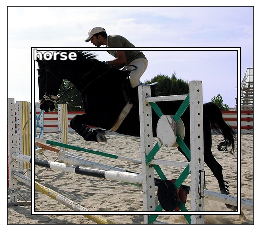

In [118]:
im = Image.open(JPEGS/im0_d[FILE_NAME]).convert('RGB')
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

In [121]:
im0_d

{'file_name': '2008_000008.jpg', 'height': 442, 'width': 500, 'id': 2008000008}

In [125]:
def open_image(path): return Image.open(path).convert('RGB')

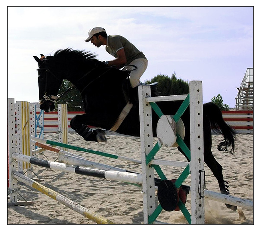

In [126]:
path = JPEGS/im0_d[FILE_NAME]
im = open_image(path)
ax = show_img(im)

In [133]:
# draw image with annotation 
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    # draw bbox/class
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b) # bounding box
        draw_text(ax, b[:2], cats[c], sz=16)
        
def draw_idx(i):
    im_a = trn_anno[i] #annotation
    im = open_image(JPEGS/trn_fns[i])
#     print(im.shape)
    draw_im(im, im_a)

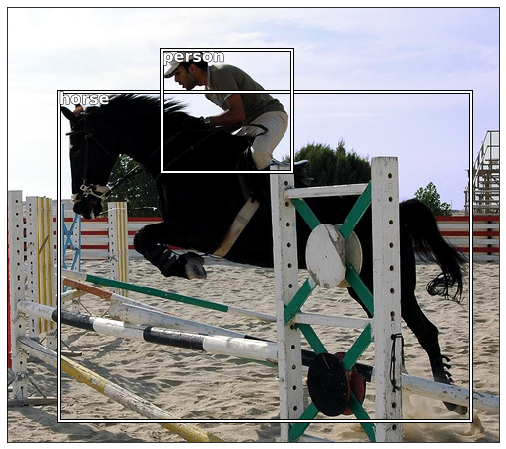

In [134]:
trn_anno[trn_ids[0]]
draw_idx(trn_ids[0])

## 3. Largest Item classifier